# RandomNets: Short tutorial

RandomNets is a model that builds implicit ensembles in a joint pytorch-lightning neural network architecture, thus making management of models easy and efficient. Here is a short tutorial showing how to use the datamodule and model, with training, inference and prediction validation.

First some imports that we'll need.

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt

from rdkit import Chem

from sklearn.metrics import r2_score, mean_squared_error

import torch
import pytorch_lightning
from pytorch_lightning import loggers as pl_loggers

from tensorboard.backend.event_processing import event_accumulator
import numpy as np
from scipy.ndimage import gaussian_filter1d


from randomnets.model import RandomNetsModel
from randomnets.datamodule import FpsDatamodule

/home/esben/git/scikit-mol/scikit_mol/fingerprints/morgan.py:70: DeprecationWarning: nBits will be replaced by fpSize, due to changes harmonization!
  self.nBits = nBits


We'll download a playset of SLC6A4 from Zenodo, but any CSV file with a smiles column and target column could do.

 SLC6A4 is also known as the serotonin transporter gene (5-HTT). Serotonin transporters plays a crucial role in regulating serotonin levels in the brain. This gene encodes a protein that is responsible for the reuptake of serotonin—a neurotransmitter involved in mood, emotion, and behavior, from the synaptic cleft back into the presynaptic neuron. By controlling serotonin reabsorption, SLC6A4 significantly influences the signaling strength and duration of this neurotransmitter.

Variations in the SLC6A4 gene, particularly in its promoter region (known as 5-HTTLPR), are associated with differences in serotonin transporter expression. These variations have been linked to susceptibility to mental health conditions such as depression, anxiety, and stress-related disorders. Understanding SLC6A4’s function and its genetic variability could help develop targeted treatments for mood disorders and enhance the efficacy of personalized medicine approaches.

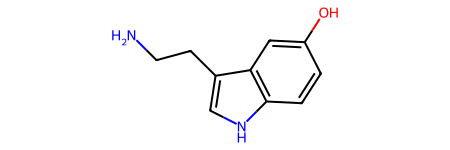

In [3]:
serotonin = Chem.MolFromSmiles("C1=CC2=C(C=C1O)C(=CN2)CCN")
serotonin

In [4]:

csv_file = "SLC6A4_active_excape_export.csv"
if not os.path.exists(csv_file):
    import urllib.request
    url = "https://ndownloader.figshare.com/files/25747817"
    urllib.request.urlretrieve(url, csv_file)
data = pd.read_csv(csv_file)
data.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,AZMKBJHIXZCVNL-BXKDBHETNA-N,44590643,6532,A,5.68382,pubchem,393260,9606,SLC6A4,4061,FC1=CC([C@@H]2O[C@H](CC2)CN)=C(OC)C=C1
1,AZMKBJHIXZCVNL-UHFFFAOYNA-N,11492305,6532,A,5.16210,pubchem,393258,9606,SLC6A4,4061,FC1=CC(C2OC(CC2)CN)=C(OC)C=C1
2,AZOHUEDNMOIDOC-GETDIYNLNA-N,44419340,6532,A,6.66354,pubchem,276059,9606,SLC6A4,4061,FC1=CC=C(C[C@H]2C[C@@H](N(CC2)CC=C)CCCNC(=O)NC...
3,AZSKJKSQZWHDOK-VJSLDGLSNA-N,CHEMBL1080745,6532,A,6.96000,chembl20,617082,9606,SLC6A4,4061,C=1C=C(C=CC1)C2=CC(=C(N2CC(C)C)C)C(NCCCN3CCN(C...
4,AZTPZTRJVCAAMX-UHFFFAOYNA-N,CHEMBL578346,6532,A,8.00000,chembl20,596934,9606,SLC6A4,4061,C1=CC=C2C(=C1)C=C(C(N(C3CCNCC3)C4CCC4)=O)C=C2


Now we can set the `ensemble_size`. Values around 25-50 are where performance saturates for this dataset. Batch-sizes should be kept fairly low, as the implicit ensemble efficiently smoothes out the training signal. 

A little note on the setting for validation. `dedicated_val` is set to `True`, so a random selection of molecules will be split off for the validation set. If it's `False`, and `sample_mask_thr` is > 0, validation will instead be done via pseudo-cross validation. Samples will be assiociated with certain members of the ensemble with a fixed feature mask, this sample_mask is inverted for the validation set, so that validation will be done on samples with feature masks that was not used during training. There's is however some data leakage through the shared weights, so it's not as sensitive signal for overfitting as a proper CV or dedicated validation set.

In [39]:
ensemble_size = 25

dm = FpsDatamodule(csv_file = csv_file, batch_size=8, dedicated_val=True, val_sample_size= 0.1, sample_mask_thr=0.0, smiles_column="SMILES", target_column="pXC50", n_nns=ensemble_size)
dm.setup(None)
traindl = dm.train_dataloader()
batch = next(iter(traindl))
batch

[tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([6.1900, 6.5400, 6.5700, 7.7213, 7.8000, 7.9914, 6.5300, 6.4685]),
 tensor([[16,  7,  0, 13, 11, 15,  8,  4, 17, 19,  6, 12,  9, 18,  1, 14,  2, 21,
           5, 10, 22, 23, 20, 24,  3],
         [ 0, 16, 11, 15,  6, 14,  7, 22, 13,  8,  3,  4, 17,  5,  2, 23,  1, 24,
           9, 10, 20, 21, 18, 12, 19],
         [ 9, 19, 23, 16,  7,  2,  8, 14, 22, 21,  0, 15,  3, 13, 12, 17, 24,  4,
          10,  6, 20, 18,  5,  1, 11],
         [23,  8, 18, 16, 10,  6, 17, 20, 24, 22,  7, 12,  1, 13, 19, 14,  2, 11,
           0, 21,  5,  4, 15,  3,  9],
         [23, 22, 14, 24, 10, 11,  7,  4,  6, 17,  0, 20, 13,  3,  8,  1, 19, 21,
          18, 16, 12, 15,  5,  9,  2],
         [11, 12,  8, 13, 15, 24, 19,  5, 22,  1, 20, 21, 

The batch consists of the fingerprints, the target value and a list of what ensemble members each sample is associated with.

Next up is building the model. It's a pytorch-lightning model, so there's a lot of features baked right in. Read more in Pytorch-Lightning excellent [documentation](https://lightning.ai/docs/pytorch/stable/)

In [22]:
model = RandomNetsModel(max_epochs=25, mask_thr=0.5, n_nns=ensemble_size, n_hidden_layers=1)
with torch.no_grad():
    out = model.forward(batch[0],batch[2]) #Need both the features and the sample mask when we do a manual forward step
out # We get out the predictions from all the enseble members.

tensor([[ 3.9150e-03,  2.5928e-02,  3.8266e-02, -1.4127e-02, -1.5064e-02,
          2.1975e-02,  2.9971e-02,  1.3004e-02,  1.9496e-02,  1.1556e-02,
          1.3137e-02, -8.8339e-03,  1.9940e-02,  1.0859e-02, -2.9629e-03,
          2.9533e-02,  8.1753e-05,  1.8328e-02, -1.0422e-02,  1.4874e-02,
          1.7320e-02, -1.3156e-02,  5.6811e-03, -1.1329e-02,  1.7923e-02,
         -9.1782e-03,  1.3058e-02, -1.7897e-02,  2.6665e-03,  7.3230e-03,
         -5.6460e-03,  5.3078e-03, -1.2911e-03,  9.7859e-03,  3.1242e-02,
         -2.5414e-03, -3.0142e-04,  5.2009e-03, -8.6895e-03,  4.1946e-03,
         -9.6407e-03,  3.2221e-03,  1.5000e-02,  7.1328e-03, -1.3711e-02,
          2.9409e-02, -3.2000e-04, -4.3796e-03, -2.9846e-03, -3.4668e-03],
        [ 9.1325e-04, -2.1840e-02,  2.2704e-02, -9.7744e-03,  1.4005e-02,
          2.2452e-02, -3.8874e-02, -1.2169e-02,  1.0408e-02, -9.9455e-03,
          5.3192e-03,  2.5201e-02,  2.2042e-02, -1.4415e-02,  4.2156e-03,
          5.0985e-02,  9.4173e-03,  1

With forward we get the output of all ensemble members (if you want to do your own statistics), but as We'll see after training, there are some convenience functions to directly get the mean and standard deviation for each sample.

Training is done with Pytorch-Lighnings trainer and logging can be done via the TensorBoard logger.

Maybe we need a few more epochs for full training, but this a short demo.

In [7]:
tb_logger = pl_loggers.TensorBoardLogger(
    save_dir="simple_training_log", default_hp_metric=None
)
trainer = pytorch_lightning.Trainer(
    max_epochs=model.max_epochs,
    devices="auto",
    log_every_n_steps=10,
    logger=tb_logger,
    enable_progress_bar=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model, dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type       | Params
---------------------------------------------
0 | dropout_fn    | Dropout    | 0     
1 | activation_fn | LeakyReLU  | 0     
2 | embedding_nn  | Conv1d     | 4.2 M 
3 | embedding     | Sequential | 4.2 M 
4 | FF            | Sequential | 0     
5 | predict_nn    | Conv1d     | 1.0 K 
---------------------------------------------
4.2 M     Trainable params
0         Non-trainable params
4.2 M     Total params
16.785    Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=25` reached.


It's possible to use tensorboards server by typing `tensorboard --logdir simple_training_log`but for documentation purposes, we'll do some inline notebook plotting.

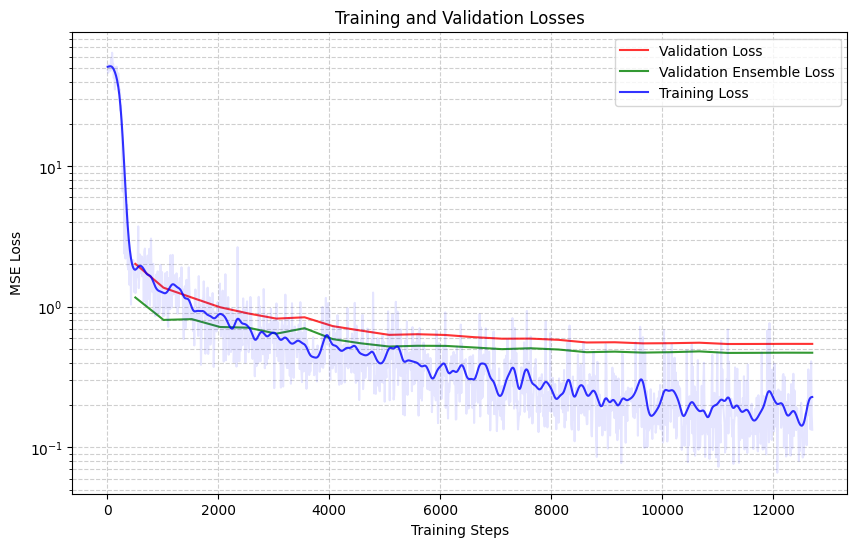

In [9]:
def load_tensorboard_data(path, scalars=['val_mse_loss', 'val_mse_ensemble_loss', 'train_mse_loss']):
    # Load the TensorBoard data
    ea = event_accumulator.EventAccumulator(path)
    ea.Reload()
    
    # Extract the data
    data = {}
    for scalar in scalars:
        if scalar in ea.scalars.Keys():
            events = ea.Scalars(scalar)
            steps = [event.step for event in events]
            values = [event.value for event in events]
            data[scalar] = {'steps': steps, 'values': values}
    
    return data

def plot_smoothed_losses(data, sigma=5):
    plt.figure(figsize=(10, 6))
    
    colors = {'train_mse_loss': 'blue', 
              'val_mse_loss': 'red',
              'val_mse_ensemble_loss': 'green'}
    
    labels = {'train_mse_loss': 'Training Loss', 
              'val_mse_loss': 'Validation Loss',
              'val_mse_ensemble_loss': 'Validation Ensemble Loss'}
    
    for metric, values in data.items():
        if metric == 'train_mse_loss':
            # Apply Gaussian smoothing only to training loss
            smoothed = gaussian_filter1d(values['values'], sigma=sigma)
            plt.plot(values['steps'], smoothed, 
                    label=labels.get(metric, metric),
                    color=colors.get(metric, 'gray'),
                    alpha=0.8)
            # Plot original training data with low opacity
            plt.plot(values['steps'], values['values'], 
                    color=colors.get(metric, 'gray'),
                    alpha=0.1)
        else:
            # Plot validation losses without smoothing
            plt.plot(values['steps'], values['values'], 
                    label=labels.get(metric, metric),
                    color=colors.get(metric, 'gray'),
                    alpha=0.8)

    plt.xlabel('Training Steps')
    plt.ylabel('MSE Loss')
    plt.yscale('log')
    plt.grid(True, which='both', linestyle='--', alpha=0.6)
    plt.legend()
    plt.title('Training and Validation Losses')
    
    return plt.gcf()

# Usage
tensorboard_path = 'simple_training_log/lightning_logs/version_2'
data = load_tensorboard_data(tensorboard_path)
fig = plot_smoothed_losses(data)

If we need to load a specific checkpoint, it can be done like this:

In [36]:
model = RandomNetsModel.load_from_checkpoint("simple_training_log/lightning_logs/version_2/checkpoints/epoch=24-step=12700.ckpt")


To get the predictions using a dataloader, we can use the method predict_dataloader. There's also a predict ensemble, there simply takes a pytorch array with the fingerprints.

Let's do that and see how the model prediction looks with some plots.

In [40]:
model.to("cpu")
test_dl = dm.test_dataloader()
y_hat_means, y_hat_stds = model.predict_dataloader(test_dl, std=True)

As the test_dl does not shuffle the dataset, we can get the true values from the batches. Otherwise we would have to get it from the embedded dataframe in the dataloader.

In [41]:
ys = [batch[1].numpy() for batch in test_dl]
ys = np.concatenate(ys)
ys

array([6.04   , 7.18046, 6.48   , ..., 8.18046, 8.8    , 6.39362],
      dtype=float32)

We can do some manual scoring, here using score functions from Scikit-Learn.

In [42]:
r2 = r2_score(ys, y_hat_means)
mse = mean_squared_error(ys, y_hat_means)

print(f"R2: {r2:.3f}, MSE: {mse:.3f}")

R2: 0.660, MSE: 0.482


And a scatter-plot for visual inspection.

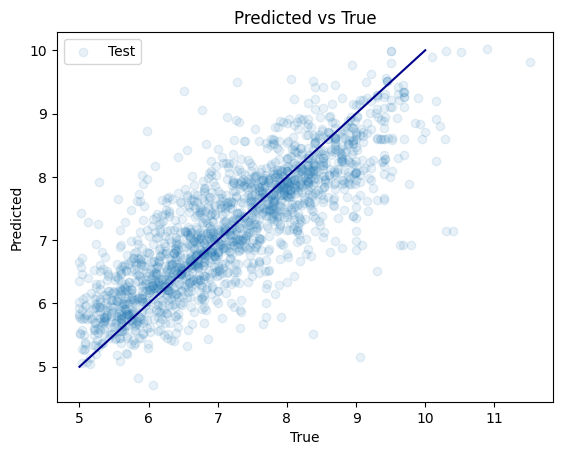

In [48]:
plt.plot(*[[5, 10]] * 2, c="darkblue")
plt.scatter(ys, y_hat_means,  alpha=0.1, label= "Test")
plt.xlabel("True")
plt.ylabel("Predicted")
plt.title("Predicted vs True")
plt.legend()
plt.show()

It looks like a nice model. But being an ensembled method, we get some extra information in the form of the standard deviation. Let's try to predict some famous drugs and see how the model predicts on them.

In [49]:
from rdkit import Chem
smiles_dict = {
    "Morphine": "CN1CC[C@]23[C@@H]4[C@H]1CC5=C2C(=C(C=C5)O)O[C@H]3[C@H](C=C4)O",
    "Viagra": "CCCC1=NN(C2=C1N=C(NC2=O)C3=C(C=CC(=C3)S(=O)(=O)N4CCN(CC4)C)OCC)C",
    "Cocaine": "CN1[C@H]2CC[C@@H]1[C@H]([C@H](C2)OC(=O)C3=CC=CC=C3)C(=O)OC",
    "Aspirin": "CC(=O)OC1=CC=CC=C1C(=O)O"
}
mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_dict.values()]
fps = dm.skmol_trf.transform(mols) #Using the ScikitMol transformer from the datamodule
mols_y_hats, mols_y_hat_stds = model.predict(torch.tensor(fps, dtype=torch.float), std=True)

If the standard deviation is too high, the ensemble is uncertain about the molecule and maybe we shouldn't trust the prediction. Depending on temperament and use-case the threshold could be set to include 95% of the samples from the test-set. It sounds very statistic with 95% percentile and this threshold should enable os to catch most true ligand, while filtereing out only a fraction of the known binders from the testset. 

In [50]:
threshold = np.percentile(y_hat_stds, 95)
print(f"Threshold: {threshold:.2f}")

Threshold: 0.46


Let's plot the predictions and the standard deviation together with a scatter plot of the test set and their standard deviations.

Text(0, 0.5, 'Error')

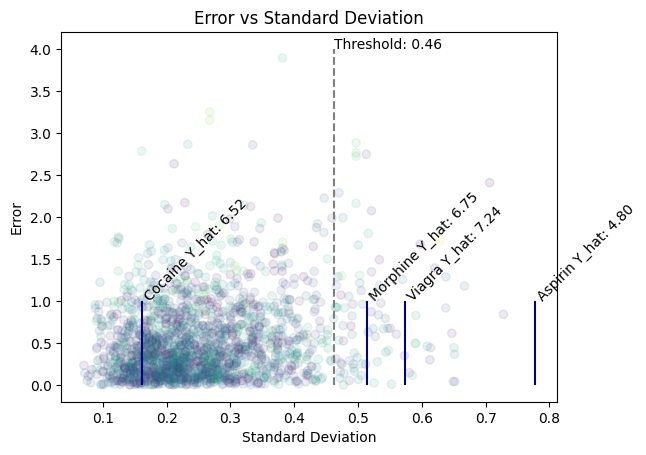

In [51]:

plt.scatter(y_hat_stds, np.abs(y_hat_means - ys), alpha=0.1, c=ys)
for i, (y_hat_mean, y_hat_std) in enumerate(zip(mols_y_hats, mols_y_hat_stds)): 
    plt.vlines(y_hat_std, 0, 1, color='darkblue')
    plt.text(y_hat_std, 1, f"{list(smiles_dict.keys())[i]} Y_hat: {y_hat_mean:.2f}", rotation=45)
plt.vlines(threshold, 0, 4, color='grey', linestyle='--')
plt.text(threshold, 4, f"Threshold: {threshold:.2f}", rotation=0)
plt.title("Error vs Standard Deviation")
plt.xlabel("Standard Deviation")
plt.ylabel("Error")

Depending on your model training, the standard deviations may look different, but it seems fairly consistent that cocaine is predicted as within the predictive domain of the model, whereas Aspirin, Morphine and Sildenafil (Viagra) may not be correctly predicted as they have a higher standard deviation in the ensemble predictions. It's not a failsafe measure though. 

Cocaine is actually active on Serotonin transporters, so this indeed seeems plausible. [https://go.drugbank.com/drugs/DB00907](https://go.drugbank.com/drugs/DB00907)

It actually turns out to be part of the training set.

In [52]:
can_smiles_train = [Chem.MolToSmiles(mol) for mol  in dm.data_train.ROMol]

can_smiles_cocaine = Chem.MolToSmiles(Chem.MolFromSmiles(smiles_dict["Cocaine"])) #Default for MolToSmiles is to canonicalize
can_smiles_cocaine in can_smiles_train



True

I hope this short tutoral gave some hints about how efficient ensemble approaches can be in QSAR modelling, and how easy and efficient they can be handled with vectorized and implicit solutions.